## Predictive Analytics

Will a customer buy a product from a particular product category when they enter the shop?

We will arrive at answer by using a statistical model that estimates purchase probabilty for each customer for each shopping trip.
Then, we will calcualte price elasticity of purchase probability under different conditions.

We'll you logistic regression to determind purchase incidences.

In [26]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

import pickle

### Data Preparation

In [12]:
# Import data
df_purchase = pd.read_csv(r'C:\Users\ml258\Python\365\Customer_analytics2\Purchase_analytics\purchase data.csv')

# Import Scaler
scaler = pickle.load(open(r'C:\Users\ml258\Python\365\Customer_analytics2\Segment_analytics\scaler.pickle', 'rb'))

# Import PCA
pca = pickle.load(open(r'C:\Users\ml258\Python\365\Customer_analytics2\Segment_analytics\pca.pickle', 'rb'))

# Import K-means
kmeans_pca = pickle.load(open(r'C:\Users\ml258\Python\365\Customer_analytics2\Segment_analytics\kmeans_pca.pickle', 'rb'))

# Standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)
# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)
# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()
# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

In [13]:
df_pa.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,47,1,110866,1,0,2,0,0,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,47,1,110866,1,0,2,0,0,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0


### Purchase Probability Model

In [14]:
# Our dependent features
Y = df_pa['Incidence']

In [15]:
# Let create an average price of candy bars

X = pd.DataFrame()

X['Mean_price'] = (
    df_pa['Price_1'] +
    df_pa['Price_2'] +
    df_pa['Price_3'] +
    df_pa['Price_4'] +
    df_pa['Price_5'] ) / 5

In [16]:
model_purchase = LogisticRegression(solver = 'sag')

model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [17]:
model_purchase.coef_

array([[-2.34746941]])

By the sign of the coef, we know that a decrease in price will lead to an increase in purchase probablity.  

## Price Elasticity of Purchase Probability

In [18]:
df_pa[['Price_1','Price_2', 'Price_3', 'Price_4', 'Price_5' ]].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [19]:
# We introduce the price range for which we'll examine the purchase probability.
# We choose a price range between 0.5 and 3.49, which somewhat expands the actual observed price range, 
# which is from 1.1 to 2.8.

price_range = np.arange(0.5, 3.5, 0.01)

df_price_range = pd.DataFrame(price_range)

In [22]:
# We predict the purchase probability for our newly defined price range. 
# The result is a 2x300  array. The first column shows the probability for not purchasing the product, 
# the second the probability for purchase for each price point in our price range.

Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

We can calculate the purchase probabilty elasticity with this formula:

$$
E=\frac{\frac{\Delta \operatorname{Pr}(\text { purchase })}{\operatorname{Pr}(\text { purchase })}}{\frac{\Delta \text { Price }}{\text { Price }}}=\frac{\Delta \operatorname{Pr}(\text { purchase })}{\Delta \text { Price }} * \frac{\text { Price }}{\operatorname{Pr}(\text { purchase })}
$$

We can also do it like:
$$
E=\text { beta } * \text { price } *(1-\operatorname{Pr}(\text { purchase }))
$$


In [23]:
price_elasticity = model_purchase.coef_[:, 0] * price_range * (1-purchase_pr)

In [24]:
df_price_elasticities = pd.DataFrame(price_range)

df_price_elasticities = df_price_elasticities.rename(columns={
    0:'Price_Point'
})

df_price_elasticities['Mean_PE'] = price_elasticity
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096309
1,0.51,-0.100373
2,0.52,-0.104563
3,0.53,-0.108884
4,0.54,-0.113338
...,...,...
295,3.45,-8.010688
296,3.46,-8.035935
297,3.47,-8.061147
298,3.48,-8.086326


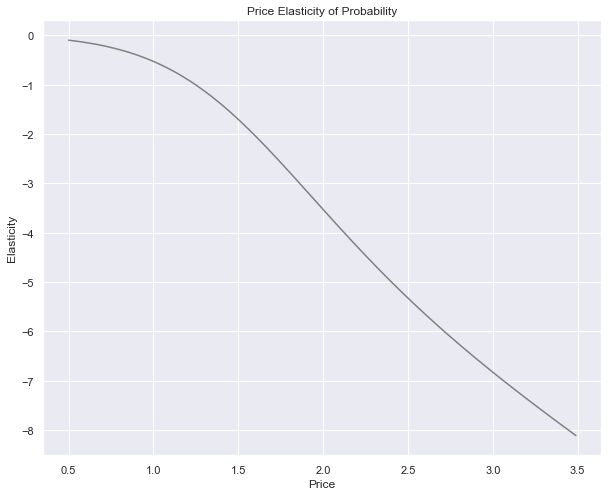

In [27]:
plt.figure(figsize=(10,8))
plt.plot(price_range, price_elasticity, color='grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Probability')
plt.show()

In [36]:
# Let's take a look at where the elasticity goes from being in-elastic to elastic.
# It's at the point where Mean_PE is equal to -1.00
df_price_elasticities[df_price_elasticities['Mean_PE'].between(-1.07, -0.88)]

,Price_Point,Mean_PE
70,1.20,-0.890571
71,1.21,-0.912470
72,1.22,-0.934731
73,1.23,-0.957355
74,1.24,-0.980342
75,1.25,-1.003693
76,1.26,-1.027406
77,1.27,-1.051482


We look for the point where the Mean_PE is closest to -1.00 \
At this point, we find where the price elasticity goes from being in-elastic to elastic.
With prices lower than Price_Point 1.25, we can increase our product price without loosing too much in terms of purchase probability.
For prices higher than 1.25, we have more to gain by reducing our prices. 

## Purchase Probability by Segments

#### Segment 1 - Career-Focused

In [41]:
# We filter the data to contain only customers from segment 1, the career-focused.
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

# Again we want to predict the purchase probability, so our Y variable is the incidence column.
# Only here we select only the customers from the first segment.
Y = df_pa_segment_1['Incidence']

X = pd.DataFrame()

# We calculate the average price for purchases in segment 1. Our dependant variable contains the mean price of the brands.
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

In [42]:
# Fit logistic regression model
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

LogisticRegression(solver='sag')

In [43]:
model_incidence_segment_1.coef_

array([[-1.71185604]])

In [44]:
Y_segment1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1  = Y_segment1[:][:, 1]
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

### Results

In [47]:
df_price_elasticities['PE_Segment_1'] = pe_segment_1
df_price_elasticities[df_price_elasticities['PE_Segment_1'].between(-1.07, -0.88)]

,Price_Point,Mean_PE,PE_Segment_1
81,1.31,-1.151397,-0.880726
82,1.32,-1.177274,-0.896691
83,1.33,-1.203507,-0.912829
84,1.34,-1.230094,-0.929140
85,1.35,-1.257034,-0.945623
86,1.36,-1.284324,-0.962277
87,1.37,-1.311961,-0.979102
88,1.38,-1.339944,-0.996097
89,1.39,-1.368268,-1.013262
90,1.40,-1.396932,-1.030595


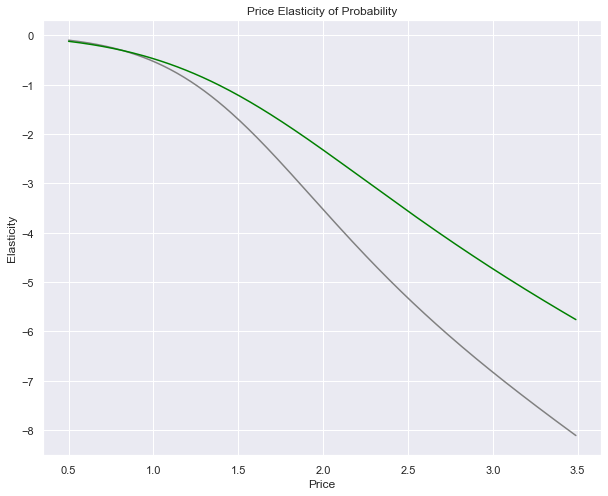

In [46]:
plt.figure(figsize=(10,8))
plt.plot(price_range, price_elasticity, color='grey')
plt.plot(price_range, pe_segment_1, color='green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Probability')
plt.show()

The purchase probabity of the career-focused looks to be less elastic than the average.
If we take a look at the dataframe above, we'll see that segment 1 becomes elastic at the pricepoint of $1.39. That's $0.14 higher than the average turning point.

So in this case, we would increase prices if we between 0.5 to 1.39 range. And thinking about decreasing above that if we want to target the career-focused segement.

#### Segment 2 - Fewer-Opportunities

In [48]:
# Select only customers from segment 2, the fewer-opportunities.
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]

In [49]:
# Logistic regression model
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

In [52]:
df_price_elasticities['PE_Segment_2'] = pe_segment2
df_price_elasticities[df_price_elasticities['PE_Segment_2'].between(-1.07, -0.88)]

,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2
73,1.23,-0.957355,-0.759269,-0.884287
74,1.24,-0.980342,-0.773840,-0.917782
75,1.25,-1.003693,-0.788586,-0.952281
76,1.26,-1.027406,-0.803507,-0.987796
77,1.27,-1.051482,-0.818602,-1.024342
78,1.28,-1.075919,-0.833872,-1.061932


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

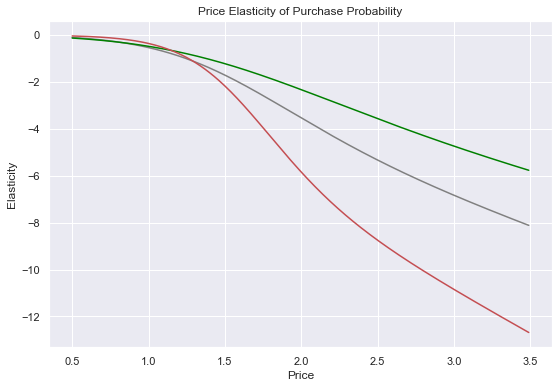

In [51]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')